In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os,sys
from datetime import datetime
from scipy.signal import detrend

import warnings
warnings.filterwarnings("ignore")

### An alternative way of calculating SAM index using u 

In [2]:
#ds= xr.open_dataset("saved_on_disk.nc")
indir='/work/bk1377/b382037/WP7/ERA5/' #before1979

#for year in range(1940,1950):
#    inputfile = indir+'ERA5_500hPa_geop_1D_'+str(year)+'_regular.nc'
#    ds= xr.open_mfdataset(inputfile)

ds_u = xr.open_mfdataset(''+indir+'ERA5_250_500_700_850hPa_u_6H_*_regular.nc', concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override')


select_end_timestep=365*4*3

In [3]:
#ds_u=ds_u.isel(time=slice(0,select_end_timestep))
ds_u['time'] = pd.to_datetime(ds_u['time'].values, format='%Y%m%d')

#condition_u = (ds_u['lat'] <= 0)
## Apply the condition to select data within the latitude range
#computed_condition_u = condition_u.compute()
#ds_u = ds_u.where(computed_condition_u, drop=True)

In [4]:
#condition_reg = (ds_u['lat'] <= 0)
condition_reg = (ds_u['lat'] > -90) & (ds_u['lat'] <= -20)
# Apply the condition to select data within the latitude range
computed_condition_reg = condition_reg.compute()
ds_u = ds_u.where(computed_condition_reg, drop=True)

### for EOF calculation 

In [5]:
daily_u = ds_u.resample(time='D').mean()

In [6]:
ubar = daily_u.mean(dim="lon", skipna=True)

In [7]:
ubar = ubar.isel(plev=[0,1,3])

In [8]:
ubar

<xarray.Dataset>
Dimensions:  (time: 16071, plev: 3, lat: 249)
Coordinates:
  * lat      (lat) float64 -89.86 -89.58 -89.3 -89.02 ... -20.67 -20.39 -20.11
  * plev     (plev) float64 2.5e+04 5e+04 8.5e+04
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-31
Data variables:
    u        (time, plev, lat) float32 dask.array<chunksize=(1, 3, 249), meta=np.ndarray>

In [9]:
del daily_u

In [10]:
### pressure-weighted vertical average : sum (A*p*dp) /sum (p*dp)
### But after testing, I think Simpson et al. (2013) used the following:
### pressure-weighted vertical average : sum (A*dp) /sum (dp) 
#weights =  ubar['plev']

pweights = xr.DataArray(
    data=np.array([250,300,250]),
    dims=["plev"])
pweights.name = "weights"

In [11]:
ubar_weimean  = ubar['u'].weighted(pweights).mean(dim='plev')

In [12]:
print(ubar_weimean[0,150].values)

21.219702124595642


In [13]:
ubar_weimean

<xarray.DataArray 'u' (time: 16071, lat: 249)>
dask.array<truediv, shape=(16071, 249), dtype=float64, chunksize=(1, 249), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.86 -89.58 -89.3 -89.02 ... -20.67 -20.39 -20.11
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-31

In [14]:
del ubar

### Detrending 

In [15]:
def detrend_dim(da, dim, deg=1):
    """detrend along a single dimension"""
    # calculate polynomial coefficients
    p = da.polyfit(dim=dim, deg=deg, skipna=False)
    # evaluate trend
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    # remove the trend
    return da - fit

detrended = detrend_dim(ubar_weimean, dim='time')

In [16]:
detrended

<xarray.DataArray (time: 16071, lat: 249)>
dask.array<sub, shape=(16071, 249), dtype=float64, chunksize=(1, 249), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.86 -89.58 -89.3 -89.02 ... -20.67 -20.39 -20.11
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-31

In [17]:
detrended=detrended.to_numpy()

In [18]:
print(detrended.shape)

(16071, 249)


In [21]:
ny=detrended.shape[1]

### Deseasonalizing

In [19]:
from scipy.fftpack import rfft, irfft, fftfreq, fft

nt=detrended.shape[0]

t=np.arange(0, nt)
print(t.shape)

xf=fft(detrended, axis=0)

f_signal = rfft(detrended, axis=0)
w = fftfreq(detrended.shape[0], d=t[1]-t[0])

cut_f_signal = f_signal.copy()
cut_f_signal[(np.abs(w)>1/60)] = 0 
cut_signal = irfft(cut_f_signal, axis=0) 

(16071,)


In [20]:
print(cut_signal.shape)

(16071, 249)


In [22]:

detrended_u = xr.DataArray(
    data=detrended.astype(float),
    dims=['time', 'lat'],
    coords=ubar_weimean.coords) 

#ubar_weimean["detrended"]=(['time', 'lat'],  detrended.astype(float))
#ubar_weimean["detrended_60d"]=(['time', 'lat'],  cut_signal.astype(float))

detrended_u_60d = xr.DataArray(
    data=cut_signal.astype(float),
    dims=['time', 'lat'],
    coords=ubar_weimean.coords) 

In [23]:
detrended_u

<xarray.DataArray (time: 16071, lat: 249)>
array([[-0.01306138,  0.01970698,  0.08726226, ..., -4.900434  ,
        -4.77129755, -4.63294966],
       [-0.11221573, -0.18149367, -0.18496565, ..., -4.70315614,
        -4.67089434, -4.61766846],
       [ 0.0264888 ,  0.0775626 ,  0.16193833, ..., -4.56502362,
        -4.46252182, -4.36206034],
       ...,
       [-0.03944488, -0.01755019,  0.05542578, ..., -2.40760742,
        -2.35637023, -2.2847414 ],
       [-0.17128677, -0.257727  , -0.33535081, ..., -2.366549  ,
        -2.30850422, -2.23654354],
       [-0.37027095, -0.67817399, -1.00039093, ..., -1.75937463,
        -1.6544979 , -1.55208678]])
Coordinates:
  * lat      (lat) float64 -89.86 -89.58 -89.3 -89.02 ... -20.67 -20.39 -20.11
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-31

In [24]:
def func(group):
    
    x=group.to_numpy()
    nt=x.shape[0]
    #print(nt)
    t=np.arange(0, nt)
    xf=fft(x, axis=0)
    f_signal = rfft(x, axis=0)
    w = fftfreq(x.shape[0], d=t[1]-t[0])

    cut_f_signal = f_signal.copy()
    cut_f_signal[(np.abs(w)>1/30)] = 0 
    cut_signal = irfft(cut_f_signal, axis=0)

    group["detrended_30y"]=(['time', 'lat'],  cut_signal.astype(float))

    return group["detrended_30y"]


clim_test= detrended_u_60d.groupby("time.dayofyear").apply(func)

In [25]:
clim_test

<xarray.DataArray 'detrended_30y' (time: 16071, lat: 249)>
array([[ 0.03858862,  0.09532198,  0.17280853, ..., -4.69012687,
        -4.58018556, -4.46503817],
       [ 0.04122429,  0.09950358,  0.17845334, ..., -4.80401338,
        -4.69130648, -4.57315199],
       [ 0.04202498,  0.10163779,  0.18237545, ..., -4.88051157,
        -4.76812657, -4.65026568],
       ...,
       [ 0.03355348,  0.0839259 ,  0.15298984, ..., -4.39402027,
        -4.28759107, -4.1760124 ],
       [ 0.04115756,  0.1015075 ,  0.18358109, ..., -4.47910692,
        -4.37114947, -4.25840271],
       [ 0.03759515,  0.0915831 ,  0.16487005, ..., -4.5928444 ,
        -4.48383507, -4.36940306]])
Coordinates:
  * lat            (lat) float64 -89.86 -89.58 -89.3 ... -20.67 -20.39 -20.11
  * time           (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-31
    detrended_30y  (time, lat) float64 0.03859 0.09532 0.1728 ... -4.484 -4.369

In [26]:
anom_final= detrended_u-clim_test["detrended_30y"]

#anom_final= daily_value["geop"]-daily_value["geop_60d"]

In [27]:
anom_final


<xarray.DataArray (time: 16071, lat: 249)>
array([[-0.05165   , -0.075615  , -0.08554626, ..., -0.21030713,
        -0.191112  , -0.16791149],
       [-0.15344002, -0.28099725, -0.36341899, ...,  0.10085724,
         0.02041215, -0.04451648],
       [-0.01553617, -0.02407519, -0.02043712, ...,  0.31548795,
         0.30560476,  0.28820533],
       ...,
       [-0.07299837, -0.10147609, -0.09756406, ...,  1.98641285,
         1.93122084,  1.891271  ],
       [-0.21244433, -0.3592345 , -0.5189319 , ...,  2.11255792,
         2.06264525,  2.02185917],
       [-0.4078661 , -0.76975709, -1.16526098, ...,  2.83346978,
         2.82933717,  2.81731629]])
Coordinates:
  * lat            (lat) float64 -89.86 -89.58 -89.3 ... -20.67 -20.39 -20.11
  * time           (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-31
    detrended_30y  (time, lat) float64 0.03859 0.09532 0.1728 ... -4.484 -4.369

### Compute the leading EOF for the region south of 20°S

In [28]:
from eofs.standard import Eof
from eofs.examples import example_data_path

In [29]:
anom_u_SH_np = anom_final.to_numpy()

In [30]:
print(anom_u_SH_np.shape)

(16071, 249)


In [31]:
coslat = np.cos(np.deg2rad(anom_final.coords['lat'].values)).clip(0., 1.)
wgts = coslat[..., np.newaxis]
#solver = Eof(anom_u_SH_np, weights=wgts)
#
#print(wgts.T.shape)
nt = anom_u_SH_np.shape[0]
wgts2D=np.tile(wgts.T,(nt,1))
#print(wgts2D.shape)
anom_u_SH_np_weighted = np.multiply(anom_u_SH_np, wgts2D)  
# Element-wise multiplication
#C = A * B  # or np.multiply(A, B)

solver = Eof(anom_u_SH_np_weighted) # I did the weighting myself first, 
                                    # because I'm not 100% sure the "weights" function
                                    # in Eof works as I intended. 


In [32]:
eof      = solver.eofs(neofs=1)
pc       = solver.pcs(npcs=1)
pc_nor   = solver.pcs(npcs=1,pcscaling=1) 
# In Simpson et al. (2013), the PC defined there corresponds to the "pc_nor" here 

In [33]:
eof = eof*-1
pc  = pc*-1
pc_nor = pc_nor*-1

In [34]:
Weof=np.zeros_like(eof)
for lat in range(ny):
    Weof[0,lat] = eof[0,lat]/wgts[lat,0]  # Recontruct the u field by removing the weighting function  

In [35]:
recovered_u = np.matmul(pc, eof)/wgts2D  
# In Simpson et al. (2013), this is the "vertically averaged zonal wind anomaly associated with the SAM 
# A function of time and latitude.

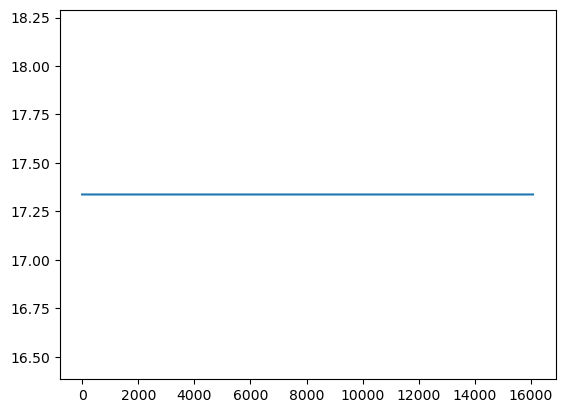

In [36]:
import matplotlib.pyplot as plt  
factor = pc/pc_nor 
plt.plot(factor)

In [37]:
print(factor[0])

[17.33731187]


In [38]:
EOF1_u = Weof*factor[0]  # The "e" in Simpson et al. (2013) (the first EOF pattern)
#EOF1_u = eof*factor[0]

In [39]:
print(EOF1_u.shape)

(1, 249)


In [40]:
print(pc_nor.shape)

(16071, 1)


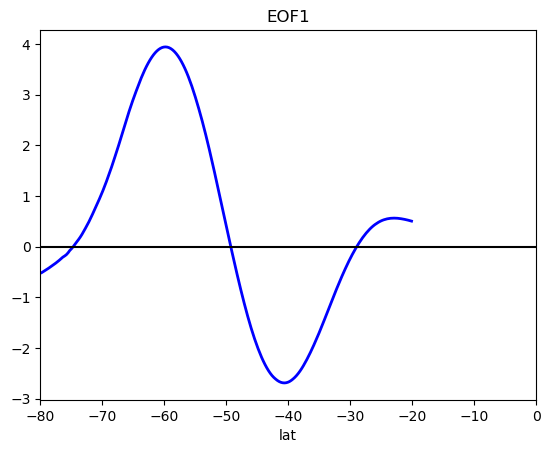

In [41]:
import matplotlib.pyplot as plt  
plt.figure()
plt.plot(anom_final.coords['lat'].values, EOF1_u[0,:],color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_xlim(-80, 0)
ax.set_xlabel('lat')
#ax.set_ylabel('meters')
ax.set_title('EOF1', fontsize=12)
#plt.text(0.95, 0.1, ''+str('{:4.1f}'.format(variance_fractions.item(0)*100))+' %' , fontsize=12, horizontalalignment='right',
#     verticalalignment='center', transform=ax.transAxes, color='b', weight='bold')

#plt.savefig('EOF1_vert_u_ERA5', bbox_inches='tight', dpi=100)
plt.show()

In [42]:
coords2= {"time":detrended_u.coords['time'], "lat":anom_final.coords['lat']}

ds_sam = xr.Dataset(
    data_vars=dict(
        u_sam=(["time", "lat"], recovered_u),
    ),
    coords=coords2,
)

In [43]:
ds_sam['SAMindex'] = (('time'),  pc_nor.flatten())

In [44]:
ds_sam['SAMeof'] = (('lat'),   EOF1_u.flatten())

In [45]:
ds_sam

<xarray.Dataset>
Dimensions:   (time: 16071, lat: 249)
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-31
  * lat       (lat) float64 -89.86 -89.58 -89.3 -89.02 ... -20.67 -20.39 -20.11
Data variables:
    u_sam     (time, lat) float64 -0.0115 -0.02304 -0.03675 ... 0.5882 0.5771
    SAMindex  (time) float64 0.371 0.1098 -0.2634 -0.2054 ... 0.9328 1.064 1.145
    SAMeof    (lat) float64 -0.03098 -0.0621 -0.09905 ... 0.523 0.5139 0.5042

In [47]:
outputFileName = 'ERA5_1980_2023_SAMindex_u_S20.nc'

print ('saving to ', outputFileName)
ds_sam.to_netcdf(path=outputFileName)
print ('finished saving')

saving to  ERA5_1980_2023_SAMindex_u_S20.nc
finished saving


In [48]:
ds_sam.close()